# MNIST on PE Network

In [138]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

In [131]:
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][:500]).float().to(device), torch.tensor(train[1][:500]).float().to(device)]

In [139]:
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][:]).float().to(device), torch.tensor(train[1][:]).float().to(device)]

In [3]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=784))  # 0 Input
net.AddLayer(Layer.PELayer(n=60))  # 1 Hidden 1
net.Connect(0,1)
net.AddLayer(Layer.PELayer(n=60))  # 2 Hidden 2
net.Connect(1,2)
net.AddLayer(Layer.TopPELayer(n=40))  # 3 Style Memory
net.Connect(2,3)
net.layers[3].SetFB()
net.AddLayer(Layer.TopPELayer(n=10))  # 4 Class vector
net.Connect(2,4)
net.layers[0].sigma = Layer.logistic
net.layers[0].sigma_p = Layer.logistic_p
net.layers[-1].sigma = Layer.softmax
net.layers[-1].sigma_p = Layer.softmax_p

In [141]:
# Shallow
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=784))  # 0 Input
net.AddLayer(Layer.TopPELayer(n=500))  # 1 Style memory
net.AddLayer(Layer.TopPELayer(n=10))  # 2 Class vector
net.Connect(0,1)
net.Connect(0,2)
net.layers[1].SetFF()  # Allow style memory to send predictions down
# Input layer is [0, 1]
net.layers[0].sigma = Layer.logistic
net.layers[0].sigma_p = Layer.logistic_p
# Style memory is [-1, 1]
net.layers[1].sigma = Layer.tanh
net.layers[1].sigma_p = Layer.tanh_p
# Class vector target is one-hot
net.layers[-1].sigma = Layer.softmax
net.layers[-1].sigma_p = Layer.softmax_p

In [132]:
# Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Class vector
net.AddLayer(Layer.TopPELayer(n=784))  # 1 Input
net.Connect(0,1)
# Input layer is one-hot
net.layers[0].sigma = Layer.softmax
net.layers[0].sigma_p = Layer.softmax_p
# Top vector reconstructed image, [0, 1]
net.layers[-1].sigma = Layer.logistic
net.layers[-1].sigma_p = Layer.logistic_p

In [142]:
net.SetTau(0.08)

In [606]:
net.layers[0].sigma = Layer.identity
net.layers[0].sigma_p = Layer.identity_p

In [3]:
net = NN.NeuralNetwork()
net.Load('MNIST 40-10 more.npy')
net.layers[0].sigma = Layer.logistic
net.layers[0].sigma_p = Layer.logistic_p
net.layers[-1].sigma = Layer.softmax
net.layers[-1].sigma_p = Layer.softmax_p
net.SetTau(0.08)

## Train

In [143]:
# sensory image -> one-hot
epochs = 5
T = 3.
start_time = time.time()
batch_size = 200
net.learning_tau = torch.tensor(batch_size).float().to(device)
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
for k in range(epochs):
    batches = NN.MakeBatches(train[0], train[1], batch_size=batch_size)
    for x in batches:
        net.Reset()
        net.Infer(T, x[0], x[1])
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

Total time: 614.5185527801514


In [135]:
# Train in reverse direction: one-hot -> reconstructed image
epochs = 1
T = 3.
start_time = time.time()
batch_size = 200
net.learning_tau = torch.tensor(batch_size).float().to(device)
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
for k in range(epochs):
    batches = NN.MakeBatches(train[1], train[0], batch_size=batch_size)
    for x in batches:
        net.Reset()
        net.Infer(T, x[0], x[1])
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

Total time: 4.410944700241089


In [136]:
net.connections[0].W

tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]], device='cuda:0')

In [144]:
net.Reset()
net.SetTau(0.04)
yy = net.Predict(3., test[0])

In [129]:
yy

tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]], device='cuda:0')

In [103]:
net.layers[-2].SetFF()

In [145]:
z = deepcopy(yy)
for idx, blah in enumerate(yy):
    z[idx,:] = torch.tensor(NN.OneHot(blah)).float()

In [146]:
err = torch.sum(torch.abs(z-torch.tensor(test[1][:len(z)]).float().to(device)))/2.
print(err)
print(len(z))

tensor(9293., device='cuda:0')
10000


In [5]:
#net.Save('MNIST 40-10 more.npy')

In [52]:
test[1][:5]

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])]

In [53]:
net.Save('MNIST 500-10.npy')

In [6]:
#net.Load('MNIST 40-10.npy')

In [53]:
net.Load('MNIST 500-10.npy')

tensor([nan., nan., nan., nan., nan., nan., nan., nan., nan., nan.], device='cuda:0')


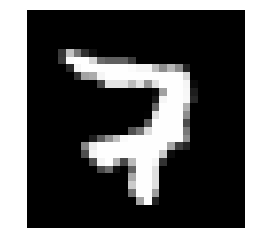

In [108]:
p = 147 #147 or 35   for 2s
p = 133 #133 or 141   for 7s
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.Reset()
net.layers[-2].SetFF()
net.layers[-2].alpha = torch.tensor(0.).float().to(device)
net.layers[-2].beta = torch.tensor(0.).float().to(device)
net.SetTau(0.04)
yy = net.Predict(10., test[0][p])
print(yy)

In [76]:
print(net.layers[-2].alpha)
print(net.layers[-2].sigma)

tensor(0., device='cuda:0')
<function tanh at 0x7f2cb107b488>


tensor([ 0.1397,  0.1021,  0.0854,  0.0895,  0.0852,  0.0931,  0.0996,
         0.1134,  0.0951,  0.0970], device='cuda:0')


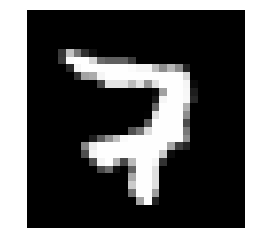

In [77]:
p = 147 #147 or 35   for 2s
p = 133 #133 or 141   for 7s
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.Reset()
net.layers[-2].SetFF()
net.SetTau(0.03)
yy = net.Predict(10., test[0][p])
print(yy)

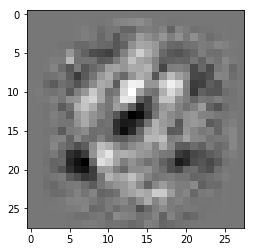

In [83]:
aug = deepcopy(net.layers[-2].v)
net.Reset()
net.SetTau(0.1)
net.layers[-2].v = torch.tensor( deepcopy(aug)).float().to(device)
net.layers[-2].alpha = 0.
net.layers[-2].beta = 0.
gen = net.Generate(15., test[1][p])
plt.imshow(np.reshape(gen,[28,28]), cmap='gray')

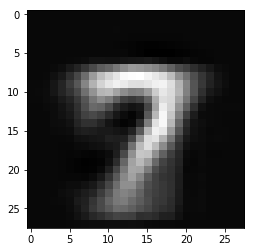

In [106]:
aug = deepcopy(net.layers[-2].v)
net.Reset()
net.SetTau(0.1)
net.layers[-2].v = torch.tensor( deepcopy(aug)).float().to(device)
net.layers[-2].alpha = 0.
net.layers[-2].beta = 0.
gen = net.Generate(15., test[1][p])
plt.imshow(np.reshape(gen,[28,28]), cmap='gray')

In [203]:
net.Save('mnist_net.npy')

In [204]:
net = NN.NeuralNetwork()
net.Load('mnist_net.npy')

In [353]:
net.Reset()
net.learning_tau = 20.
net.Infer(.2, test[0][p], test[1][p])

In [545]:
net.layers[-2].v

tensor(1.00000e-03 *
       [ 5.5711, -6.3914, -5.4448,  5.6197, -1.9968,  2.8723, -0.3154,
         0.7165,  0.1152, -1.9894,  0.8639, -0.2807,  3.3954, -4.1330,
         1.3427, -1.5900, -0.0983,  1.1545, -5.7411, -1.5865, -0.0122,
         2.3460,  5.4155, -0.3811,  3.0074, -2.6250, -7.2825,  2.4641,
         0.6985, -5.0769,  2.5862, -1.8554,  1.8538, -4.3773, -0.1637,
        -0.7635, -2.0211, -2.0069, -3.5299, -3.7638], device='cuda:0')